In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import xgboost
import numpy as np
from scipy.sparse import csr_matrix, diags
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
iris = load_iris(as_frame=True)
X, y = load_iris(return_X_y=True)
iris = iris['data']
X_train, X_test, y_train, y_test = train_test_split(X, y)

skrf = RandomForestClassifier(max_depth=3, random_state=0)
skrf.fit(X_train, y_train)
skpreds = skrf.predict(X_test)

# access trees
# trees = skrf.estimators_
leaves = skrf.apply(X_train)

In [3]:
def make_adjacency(leaves):

    n_samples, n_trees = leaves.shape
    
    # give each (tree, leaf) a unique global ID
    unique_leafIDs = []
    offset = 0
    offsets = []
    mappings = []
    for t in range(n_trees):
        col = leaves[:, t]
        # relabel leaves 
        unique, relabeled = np.unique(col, return_inverse=True)
        unique_leafIDs.append(relabeled + offset)
        mapping = {u: i for i, u in enumerate(unique)}
        mappings.append(mapping)
        offsets.append(offset)
        offset += len(unique)
    leafIDs_global = np.column_stack(unique_leafIDs)

    # Build sparse membership matrix M
    row_ind = np.repeat(np.arange(n_samples), n_trees)
    col_ind = leafIDs_global.ravel()
    data = np.ones_like(row_ind, dtype=np.float32)

    M = csr_matrix((data, (row_ind, col_ind)), shape=(n_samples, offset))

    # leaf sizes and weights
    leaf_sizes = np.array(M.sum(axis=0)).ravel()
    leaf_weights = 1.0 / np.maximum(leaf_sizes, 1)  # avoid div by zero

    M_norm = M @ diags(leaf_weights)
    A = (M_norm @ M.T) / n_trees
    
    metadata = {
        "offsets": offsets,
        "leaf_weights": leaf_weights,
        "M_norm": M_norm,
        "total_leaves": offset,
        "mappings": mappings
    }
    return A.toarray(), metadata

In [4]:
A, metadata = make_adjacency(leaves)
new_leaves = skrf.apply(X_test)

In [5]:
def new_adjacency(new_leaves, metadata):
    offsets = metadata["offsets"]
    leaf_weights = metadata["leaf_weights"]
    M_norm_train = metadata["M_norm"]
    n_new, n_trees = new_leaves.shape
    total_leaves = metadata["total_leaves"] 
    mappings = metadata["mappings"]

    new_leafIDs = []
    for t in range(n_trees):
        mapping = mappings[t]
        relabeled = np.array([mapping[lid] for lid in new_leaves[:, t]])
        new_leafIDs.append(relabeled + offsets[t])
    leafIDs_global = np.column_stack(new_leafIDs)
    row_ind = np.repeat(np.arange(n_new), n_trees)
    col_ind = leafIDs_global.ravel()

    data = np.ones_like(row_ind, dtype=np.float32)

    M_new = csr_matrix((data, (row_ind, col_ind)), shape=(n_new, total_leaves))
    M_norm_new = M_new @ diags(leaf_weights)
    A_new = (M_norm_new @ M_norm_train.T) / n_trees
    return A_new

In [6]:
A_new = new_adjacency(new_leaves, metadata)
D = 1-A

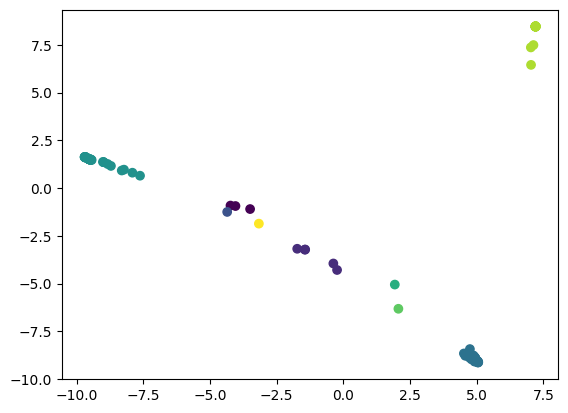

In [7]:
clustering = AgglomerativeClustering(n_clusters = None, distance_threshold = 0.1, linkage = 'single').fit(D)
clustering.labels_
# little sanity check - pca kernel data and plot to see if the clusters make sense
sc = StandardScaler()
pca_data = sc.fit_transform(D)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_data).T
plt.scatter(pca_data[0, ], pca_data[1, ], c=clustering.labels_)
plt.show() 

Looks pretty okay? 

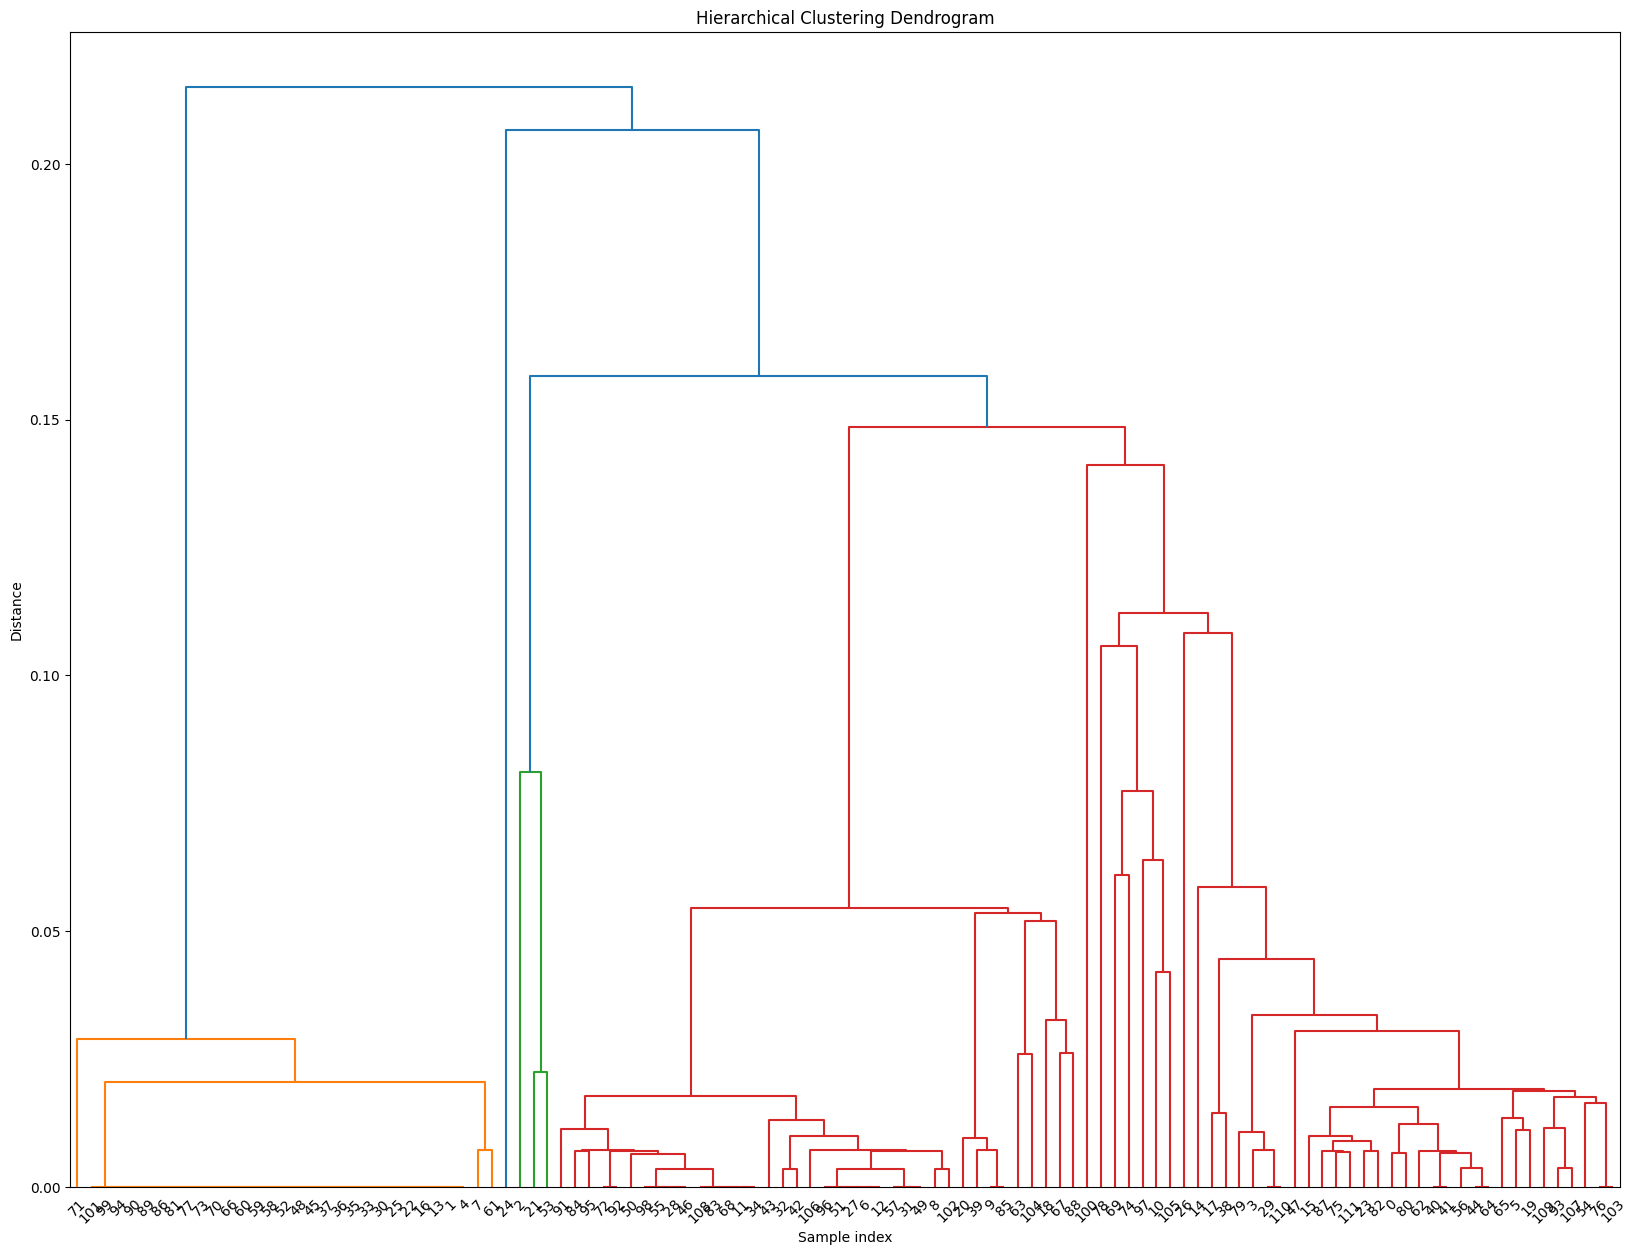

In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

Z = linkage(D, method = 'single')
plt.figure(figsize=(20, 15))
dendrogram(Z, truncate_mode=None, leaf_rotation=45, leaf_font_size=10.)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

In [9]:
rootnode, nodelist = to_tree(Z, rd=True)

In [10]:
import torch
import torch.nn as nn


In [11]:
rootnode.id

222

In [ ]:
class DDT(nn.Module):
    def __init__(self, input_dim, root, nodes, output_dim, use_cude=False):
        super(DDT, self).__init__()
        self.root = root
        self.nodes = {node.id: node for node in nodes}
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.device = torch.device("cuda" if use_cuda else "cpu")

        self.internal_node_num_ = self.output_dim - 1
        self.leaf_node_num_ = self.output_dim        

        self.inner_nodes = nn.Sequential(
            nn.Linear(self.input_dim + 1, self.internal_node_num_, bias=False),
            nn.Sigmoid(),
            nn.Linear(self.internal_node_num_, self.output_dim, bias=False)
        )

        self.split_layers = nn.ModuleDict()
        for nid, node in self.nodes.items():
            if node.left is not None and node.right is not None:
                self.split_layers[str(nid)] = nn.Sequential(
                    nn.Linear(input_dim + 1, 1, bias = False),
                    nn.Sigmoid()
                )
    def foward(self, X):
        batch_size = X.size(0)

        mu = {nid: torch.zeros(batch_size, 1, device=X.device)
              for nid in self.nodes}
        mu[self.root.id] = torch.ones(batch_size, 1, device = X.device)

        stack = [self.root.id]
        while stack:
            nid = stack.pop()
            node = self.nodes[nid]

            if node.left is None:
                continue
            
            p_left = self.split_layers[str(nid)](X)
            mu[node.left.id] += mu[nid] * p_left
            mu[node.right.id] += mu[nid] * (1 - p_left)

            stack.extend([node.left.id, node.right.id])

        leaf_probs = [mu[nid] for nid, node in self.nodes.items() if node.left is None]
        leaf_probs = torch.cat(leaf_probs, dim=1)

        return leaf_probs
    def _data_augment(self, X):
        """add bias feature as leading 1."""
        batch_size = X.size(0)
        X = X.view(batch_size, -1)
        bias = torch.ones(batch_size, 1, device=self.device)
        return torch.cat((bias, X), dim=1)

In [ ]:
data = pd.read_csv('data_42.csv', index_col=0)
input_dim = 10
output_dim

,0,1,2,3,4,5,6,7,8,9,y
0,0.304717,-0.179073,0.165948,0.559336,-0.347034,-0.879938,-0.736219,-0.800444,-0.727723,-1.026784,0.0
1,0.879398,1.130490,1.046223,1.432954,1.493441,0.969540,1.033321,0.512021,0.843727,0.737592,1.0
2,-0.184862,-0.463186,0.116026,0.037065,-0.153345,-0.291502,-0.030324,0.132002,0.298708,0.456628,0.0
3,2.141648,1.750331,1.352016,0.862099,1.044389,1.432057,1.239183,0.749049,0.314761,0.566872,1.0
4,0.743254,0.905684,0.525027,0.573721,0.567211,0.605814,0.925080,0.930035,1.132963,1.049124,1.0
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.165477,0.305701,0.621876,1.005060,-0.303974,0.482048,0.711244,1.713052,1.200739,0.311995,1.0
996,0.007218,-0.113535,0.182744,0.633020,0.531667,0.373578,0.564069,0.395931,0.208143,0.639405,1.0
997,1.259778,1.606290,1.372331,0.302386,0.207546,-0.143605,-0.185790,-0.459733,-0.422800,-0.833530,0.0
998,-1.280717,-0.619687,-0.980382,-0.882199,-0.377916,0.058412,0.399037,0.491149,0.757620,1.280373,0.0


In [12]:
leftnode = rootnode.left
leftnode.right

In [13]:
rootnode.id


222

In [14]:
rootnode.left.id

211

In [15]:
def extract_nodes(node):
    if node.is_leaf():
        return [{"id": node.id, "left": None, "right": None, "dist": 0, "count": 1}]
    else:
        left = extract_nodes(node.left)
        right = extract_nodes(node.right)
        current = [{"id": node.id, "left": node.left.id, "right": node.right.id,
                    "dist": node.dist, "count": node.count}]
        return left + right + current

# Get a flat list of all nodes
node_list = extract_nodes(rootnode)

In [16]:
node_list

[{'id': 109, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 47, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 36, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 12, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 45, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 181,
  'left': 12,
  'right': 45,
  'dist': np.float64(0.005557186108218849),
  'count': 2},
 {'id': 184,
  'left': 36,
  'right': 181,
  'dist': np.float64(0.0072821875385498305),
  'count': 3},
 {'id': 188,
  'left': 47,
  'right': 184,
  'dist': np.float64(0.008856657135684148),
  'count': 4},
 {'id': 190,
  'left': 109,
  'right': 188,
  'dist': np.float64(0.010382456732297918),
  'count': 5},
 {'id': 28, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 111, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 99, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'id': 98, 'left': None, 'right': None, 'dist': 0, 'count': 1},
 {'i

In [14]:
trees = skrf.estimators_
new_leaves

array([[1, 1, 2, ..., 1, 1, 1],
       [8, 8, 8, ..., 6, 8, 8],
       [8, 5, 7, ..., 5, 4, 4],
       ...,
       [1, 1, 2, ..., 1, 1, 1],
       [8, 8, 7, ..., 6, 5, 8],
       [4, 4, 7, ..., 4, 4, 5]], shape=(38, 100))

In [34]:
Z.shape

(111, 4)

In [16]:
tree_0 = trees[0]
print(tree_0.tree_.children_left)
print(tree_0.tree_.children_right)

[ 1 -1  3  4 -1 -1  7 -1 -1]
[ 2 -1  6  5 -1 -1  8 -1 -1]


In [38]:
Z[0]

array([59., 76.,  0.,  2.])